<a href="https://colab.research.google.com/github/kanri3/deep_learning_day1_day2/blob/main/2_1_2_vanishing_gradient_hands_on.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# vanishing gradient

指摘  
sigmoid - gauss　← 意図不明  
weightのつづりが間違っています

In [ ]:
import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# mnistをロード
# x_は 画像データ 、d_は 教師ラベルデータ で、trainは学習用データ、testはモデルの性能を評価する際に使用するデータ
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("x_train:", x_train)
print("d_train:", d_train)
print("x_test:", x_test)
print("d_test:", d_test)
print("x_train.shape:", x_train.shape)
print("d_train.shape:", d_train.shape)
print("x_test.shape:", x_test.shape)
print("d_test.shape:", d_test.shape)

print("データ読み込み完了")

# 重み初期値補正係数
weight_init = 0.01
#入力層サイズ
input_layer_size = 784
#中間層サイズ
hidden_layer_1_size = 40
hidden_layer_2_size = 20

#出力層サイズ
output_layer_size = 10
# 繰り返し数
iters_num = 2000
# ミニバッチサイズ
batch_size = 100
# 学習率
learning_rate = 0.1
# 描写頻度
plot_interval=200

x_train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
d_train: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
x_test: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
d_test: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_train.shape: (60000, 784)
d_train.shape: (60000, 10)
x_test.shape: (10000, 784)
d_test.shape: (10000, 10)
データ読み込み完了


In [ ]:
# 初期設定
def init_network():
    network = {} 
    network['W1'] = weight_init * np.random.randn(input_layer_size, hidden_layer_1_size)
    network['W2'] = weight_init * np.random.randn(hidden_layer_1_size, hidden_layer_2_size)
    network['W3'] = weight_init * np.random.randn(hidden_layer_2_size, output_layer_size)
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)
    return network

# 順伝播
def forward(network, x, hidden_f):
# def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    # hidden_f = functions.sigmoid
    u1 =  np.dot(x, W1) + b1
    z1 = hidden_f(u1)
    u2 =  np.dot(z1, W2) + b2
    z2 = hidden_f(u2)
    u3 =  np.dot(z2, W3) + b3
    y = functions.softmax(u3)
    return z1, z2, y

# 誤差逆伝播
def backward(x, d, z1, z2, y, hidden_d_f):
# def backward(x, d, z1, z2, y):
    grad = {}
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    # hidden_d_f = functions.d_sigmoid
    last_d_f = functions.d_softmax_with_loss
    # 出力層でのデルタ
    delta3 = last_d_f(d, y)
    # b3の勾配
    grad['b3'] = np.sum(delta3, axis=0)
    # W3の勾配
    grad['W3'] = np.dot(z2.T, delta3)
    # 2層でのデルタ
    delta2 = np.dot(delta3, W3.T) * hidden_d_f(z2)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * hidden_d_f(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)
    return grad

# 正答率
def accuracy(x, d, hidden_f):
# def accuracy(x, d):
    z1, z2, y = forward(network, x, hidden_f)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

# グラフ
def draw_graph(lists, accuracies_train, accuracies_test, legend_position):
    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc = legend_position)
    # plt.legend(loc="lower right")
    plt.title("accuracy")
    plt.xlabel("count")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    # グラフの表示
    plt.show()

## sigmoid

i: 199
x.shape: (10000, 784)
y.shape: (10000, 10)
y.shape: (10000,)
d.shape: (10000, 10)
np.sum(y == d): 1135
float(x.shape[0]): 10000.0
i: 199
x.shape: (100, 784)
y.shape: (100, 10)
y.shape: (100,)
d.shape: (100, 10)
np.sum(y == d): 7
float(x.shape[0]): 100.0
Generation: 200. 正答率(トレーニング) = 0.07
                : 200. 正答率(テスト) = 0.1135
i: 399
x.shape: (10000, 784)
y.shape: (10000, 10)
y.shape: (10000,)
d.shape: (10000, 10)
np.sum(y == d): 1135
float(x.shape[0]): 10000.0
i: 399
x.shape: (100, 784)
y.shape: (100, 10)
y.shape: (100,)
d.shape: (100, 10)
np.sum(y == d): 12
float(x.shape[0]): 100.0
Generation: 400. 正答率(トレーニング) = 0.12
                : 400. 正答率(テスト) = 0.1135
Generation: 600. 正答率(トレーニング) = 0.1
                : 600. 正答率(テスト) = 0.1032
Generation: 800. 正答率(トレーニング) = 0.17
                : 800. 正答率(テスト) = 0.1135
Generation: 1000. 正答率(トレーニング) = 0.13
                : 1000. 正答率(テスト) = 0.1135
Generation: 1200. 正答率(トレーニング) = 0.09
                : 1200. 正答率(テスト) = 0.1135
Generation: 

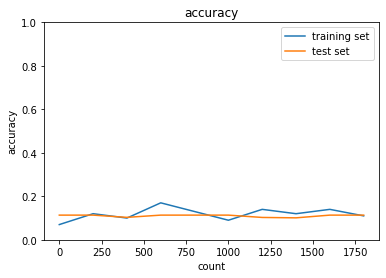

In [ ]:
# パラメータの初期化
network = init_network()
accuracies_train = []
accuracies_test = []

# 正答率（何やってる？デバッグ）
def accuracy_trace(x, d, hidden_f, i):
# def accuracy(x, d):
    z1, z2, y = forward(network, x, hidden_f)
    if i<500:
      print("i:", i)
      print("x.shape:", x.shape)
      print("y.shape:", y.shape)
    y = np.argmax(y, axis=1)
    if i<500:
      print("y.shape:", y.shape)
      print("d.shape:", d.shape)
      # print("y:", y)
      # print("d:", d)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    if i<500:
      print("np.sum(y == d):", np.sum(y == d))
      print("float(x.shape[0]):", float(x.shape[0]))
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]
    
    z1, z2, y = forward(network, x_batch, functions.sigmoid)
    grad = backward(x_batch, d_batch, z1, z2, y, functions.d_sigmoid)

    if ( i + 1 ) % plot_interval == 0 :
        accr_test = accuracy_trace(x_test, d_test, functions.sigmoid, i)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy_trace(x_batch, d_batch, functions.sigmoid, i)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]

# グラフの表示
draw_graph(lists, accuracies_train, accuracies_test, "upper right")

## ReLU（Rectified Linear Unit）

ReLU - gaussって書いてあったの意図不明

Generation: 200. 正答率(トレーニング) = 0.11
                : 200. 正答率(テスト) = 0.1135
Generation: 400. 正答率(トレーニング) = 0.12
                : 400. 正答率(テスト) = 0.1318
Generation: 600. 正答率(トレーニング) = 0.32
                : 600. 正答率(テスト) = 0.3089
Generation: 800. 正答率(トレーニング) = 0.73
                : 800. 正答率(テスト) = 0.6821
Generation: 1000. 正答率(トレーニング) = 0.82
                : 1000. 正答率(テスト) = 0.8254
Generation: 1200. 正答率(トレーニング) = 0.82
                : 1200. 正答率(テスト) = 0.8609
Generation: 1400. 正答率(トレーニング) = 0.92
                : 1400. 正答率(テスト) = 0.8778
Generation: 1600. 正答率(トレーニング) = 0.89
                : 1600. 正答率(テスト) = 0.9037
Generation: 1800. 正答率(トレーニング) = 0.96
                : 1800. 正答率(テスト) = 0.9182
Generation: 2000. 正答率(トレーニング) = 0.98
                : 2000. 正答率(テスト) = 0.9253


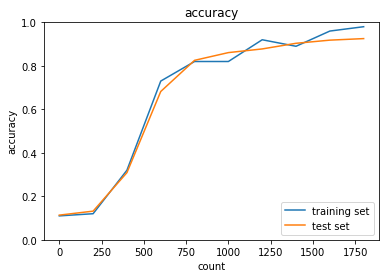

In [ ]:
# パラメータの初期化
network = init_network()
accuracies_train = []
accuracies_test = []

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]

    # z1, z2, y = forward(network, x_batch)
    # grad = backward(x_batch, d_batch, z1, z2, y)
    z1, z2, y = forward(network, x_batch, functions.relu)
    grad = backward(x_batch, d_batch, z1, z2, y, functions.d_relu)

    if ( i + 1 ) % plot_interval == 0 :
        accr_test = accuracy(x_test, d_test, functions.relu)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch, functions.relu)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]

# グラフの表示
draw_graph(lists, accuracies_train, accuracies_test, "lower right")

## sigmoid - Xavier

Generation: 200. 正答率(トレーニング) = 0.49
                : 200. 正答率(テスト) = 0.4696
Generation: 400. 正答率(トレーニング) = 0.56
                : 400. 正答率(テスト) = 0.5924
Generation: 600. 正答率(トレーニング) = 0.62
                : 600. 正答率(テスト) = 0.6577
Generation: 800. 正答率(トレーニング) = 0.62
                : 800. 正答率(テスト) = 0.6766
Generation: 1000. 正答率(トレーニング) = 0.71
                : 1000. 正答率(テスト) = 0.7215
Generation: 1200. 正答率(トレーニング) = 0.8
                : 1200. 正答率(テスト) = 0.7559
Generation: 1400. 正答率(トレーニング) = 0.76
                : 1400. 正答率(テスト) = 0.777
Generation: 1600. 正答率(トレーニング) = 0.84
                : 1600. 正答率(テスト) = 0.7922
Generation: 1800. 正答率(トレーニング) = 0.79
                : 1800. 正答率(テスト) = 0.7997
Generation: 2000. 正答率(トレーニング) = 0.75
                : 2000. 正答率(テスト) = 0.8044


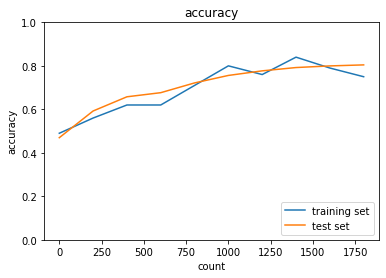

In [ ]:
# 初期設定
def init_network():
    network = {} 
    ###########  変更箇所  ##############
    # Xavierの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / (np.sqrt(input_layer_size))
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / (np.sqrt(hidden_layer_1_size))
    network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / (np.sqrt(hidden_layer_2_size))
    #################################
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)
    return network

# パラメータの初期化
network = init_network()
accuracies_train = []
accuracies_test = []

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]


    z1, z2, y = forward(network, x_batch, functions.sigmoid)
    grad = backward(x_batch, d_batch, z1, z2, y, functions.d_sigmoid)
    # z1, z2, y = forward(network, x_batch)
    # grad = backward(x_batch, d_batch, z1, z2, y)

    if ( i + 1 ) % plot_interval == 0:
        accr_test = accuracy(x_test, d_test, functions.sigmoid)
        # accr_test = accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        
        accr_train = accuracy(x_batch, d_batch, functions.sigmoid)
        # accr_train = accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]

# グラフの表示
draw_graph(lists, accuracies_train, accuracies_test, "lower right")

## ReLU - He

Generation: 200. 正答率(トレーニング) = 0.95
                : 200. 正答率(テスト) = 0.8959
Generation: 400. 正答率(トレーニング) = 0.88
                : 400. 正答率(テスト) = 0.9095
Generation: 600. 正答率(トレーニング) = 0.95
                : 600. 正答率(テスト) = 0.9263
Generation: 800. 正答率(トレーニング) = 0.93
                : 800. 正答率(テスト) = 0.934
Generation: 1000. 正答率(トレーニング) = 0.94
                : 1000. 正答率(テスト) = 0.9414
Generation: 1200. 正答率(トレーニング) = 0.93
                : 1200. 正答率(テスト) = 0.9384
Generation: 1400. 正答率(トレーニング) = 0.92
                : 1400. 正答率(テスト) = 0.9469
Generation: 1600. 正答率(トレーニング) = 0.98
                : 1600. 正答率(テスト) = 0.9484
Generation: 1800. 正答率(トレーニング) = 0.96
                : 1800. 正答率(テスト) = 0.9505
Generation: 2000. 正答率(トレーニング) = 0.95
                : 2000. 正答率(テスト) = 0.9511


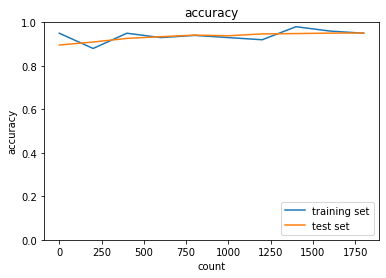

In [ ]:
# 初期設定
def init_network():
    network = {} 
    ###########  変更箇所  ##############
    # Heの初期値
    network['W1'] = np.random.randn(input_layer_size, hidden_layer_1_size) / np.sqrt(input_layer_size) * np.sqrt(2)
    network['W2'] = np.random.randn(hidden_layer_1_size, hidden_layer_2_size) / np.sqrt(hidden_layer_1_size) * np.sqrt(2)
    network['W3'] = np.random.randn(hidden_layer_2_size, output_layer_size) / np.sqrt(hidden_layer_2_size) * np.sqrt(2)
    #################################
    network['b1'] = np.zeros(hidden_layer_1_size)
    network['b2'] = np.zeros(hidden_layer_2_size)
    network['b3'] = np.zeros(output_layer_size)
    return network

# パラメータの初期化
network = init_network()
accuracies_train = []
accuracies_test = []

for i in range(iters_num):
    # ランダムにバッチを取得    
    batch_mask = np.random.choice(train_size, batch_size)
    # ミニバッチに対応する教師訓練画像データを取得    
    x_batch = x_train[batch_mask]
    # ミニバッチに対応する訓練正解ラベルデータを取得する
    d_batch = d_train[batch_mask]
    
    z1, z2, y = forward(network, x_batch, functions.relu)
    grad = backward(x_batch, d_batch, z1, z2, y, functions.d_relu)
    # z1, z2, y = forward(network, x_batch)
    # grad = backward(x_batch, d_batch, z1, z2, y)

    if ( i + 1 ) % plot_interval == 0:
        # accr_test = accuracy(x_test, d_test)
        accr_test = accuracy(x_test, d_test, functions.relu)
        accuracies_test.append(accr_test)
        
        # accr_train = accuracy(x_batch, d_batch)
        accr_train = accuracy(x_batch, d_batch, functions.relu)
        accuracies_train.append(accr_train)

        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))
        
    # パラメータに勾配適用
    for key in ('W1', 'W2', 'W3', 'b1', 'b2', 'b3'):
        network[key]  -= learning_rate * grad[key]

# グラフ
draw_graph(lists, accuracies_train, accuracies_test, "lower right")